In [1]:
import pandas as pd
from src.pipeline.select_features import get_feature_importance
from src.pipeline.pipeline import pipeline
from src.data.get_dataset import get_merged_datasets
# get merged dataframe
dataframe = get_merged_datasets()
# Remove feature we do not want to use.
dataframe.drop(columns=['year','country','iso_code'], inplace=True)

In [2]:
# check all columns are numeric (https://stackoverflow.com/questions/54426845/how-to-check-if-a-pandas-dataframe-contains-only-numeric-values-column-wise)
dataframe.dtypes

population                                                                           float64
gdp                                                                                  float64
cement_co2                                                                           float64
cement_co2_per_capita                                                                float64
co2                                                                                  float64
                                                                                      ...   
population_ages_65_and_above_(%_of_total_population)_[sp.pop.65up.to.zs]             float64
population_ages_65_and_above,_female_(%_of_female_population)_[sp.pop.65up.fe.zs]    float64
population_ages_65_and_above,_male_(%_of_male_population)_[sp.pop.65up.ma.zs]        float64
imports_of_goods_and_services_(%_of_gdp)_[ne.imp.gnfs.zs]                            float64
exports_of_goods_and_services_(%_of_gdp)_[ne.exp.gnfs.zs]             

## Transform data and perform test train split

In [3]:
x_train, x_test, y_train, y_test, feature_list = pipeline(df=dataframe)

## Get feature importance values

In [4]:
feature_importance_linear = get_feature_importance(x_train, y_train,
                                                   feature_list, type="Linear")
feature_importance_forest = get_feature_importance(x_train, y_train,
                                                   feature_list,type="RandomForest")
feature_importance_tree = get_feature_importance(x_train, y_train,
                                                 feature_list,
                                                 type="Tree")

feature_importance = pd.merge(feature_importance_linear, feature_importance_tree, left_index=True, right_index=True, how='inner',
                              suffixes=("_linear", "_tree"))
feature_importance = pd.merge(feature_importance, feature_importance_forest, left_index=True, right_index=True, how='inner')
feature_importance.rename(columns={'Importance':'Importance_forest'}, inplace=True)
feature_importance.head()

,Importance_linear,Importance_tree,Importance_forest
coal_electricity,4.200700e+14,0.000050,0.037762
electricity_generation,3.666168e+14,0.000036,0.010189
low_carbon_electricity,2.563907e+14,0.000049,0.000173
male_working_age_by_percent,1.729216e+14,0.000007,0.000664
gas_electricity,1.588794e+14,0.000059,0.000263


In [5]:
feature_list = sorted(feature_importance.index.to_list())

## Scale feature importance

In [6]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
feature_importance_abs = feature_importance.abs()
scalar.fit(feature_importance_abs)
feature_importance_abs_scaled = scalar.transform(feature_importance_abs)
feature_importance_abs_scaled = pd.DataFrame(feature_importance_abs_scaled,
                                             index=feature_importance_abs.index,
                                             columns=feature_importance_abs.columns)
feature_importance_abs_scaled

,Importance_linear,Importance_tree,Importance_forest
coal_electricity,0.591909,5.401597e-05,0.098802
electricity_generation,0.516590,3.947418e-05,0.026650
low_carbon_electricity,0.361273,5.368696e-05,0.000438
male_working_age_by_percent,0.243659,7.761492e-06,0.001724
gas_electricity,0.223873,6.425600e-05,0.000675
...,...,...,...
nuclear_electricity,0.112810,5.919430e-07,0.000767
renewables_electricity,0.129039,7.121706e-07,0.004811
female_working_age_by_percent,0.240039,1.964345e-06,0.000878
fossil_electricity,0.397673,7.038306e-04,0.114887


## Choosing feature importance by scaled abs value

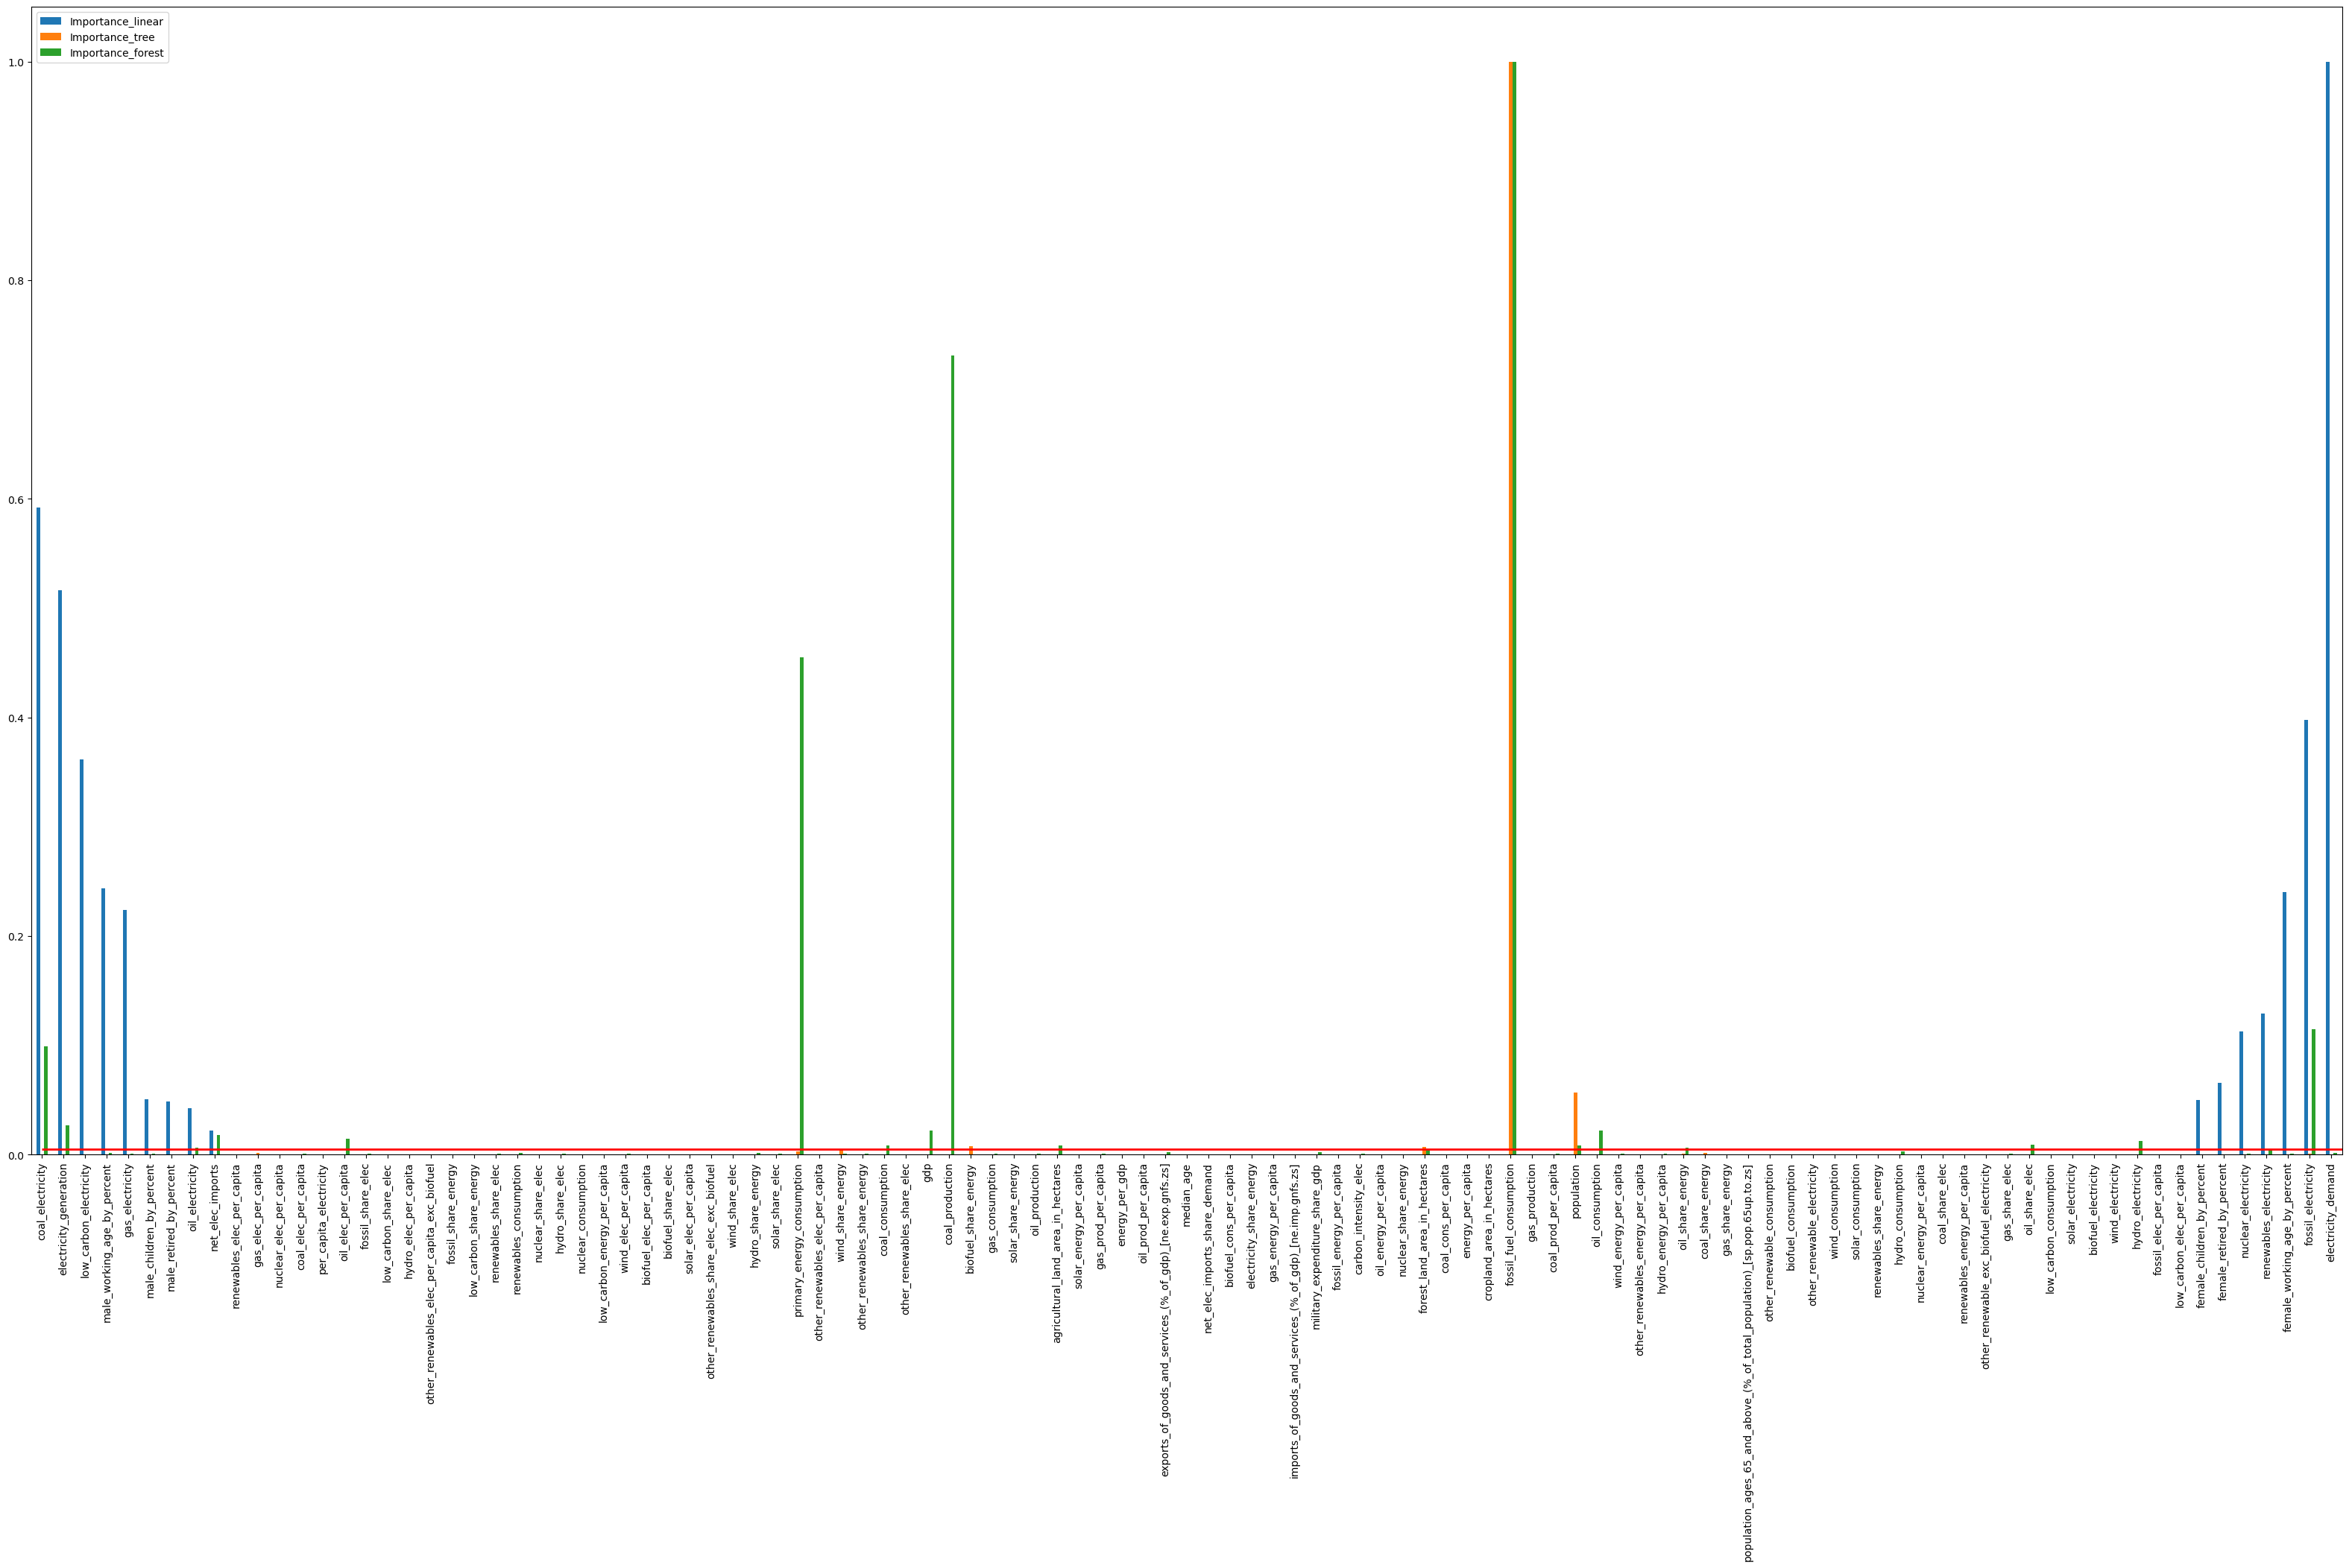

In [40]:
import matplotlib.pyplot as plt
# Set cut off value
suggested_cut_off = 0.005

plot = feature_importance_abs_scaled.plot(kind='bar', figsize=(40,20))
plot.hlines(suggested_cut_off,linewidth=2, xmin=0, xmax=len(feature_list), color='r')
plt.savefig('Feature_selection.png')


Inspect cutoff Value in saved fig. This seems reasonable.

### Get set of Selected features

In [41]:
linear_top = feature_importance_abs_scaled.index[feature_importance_abs_scaled.Importance_linear>=suggested_cut_off].tolist()
tree_top = feature_importance_abs_scaled.index[feature_importance_abs_scaled.Importance_tree>=suggested_cut_off].tolist()
forest_top = feature_importance_abs_scaled.index[feature_importance_abs_scaled.Importance_forest>=suggested_cut_off].tolist()
top_features = linear_top+tree_top+forest_top
top_features = set(top_features)
top_features

{'agricultural_land_area_in_hectares',
 'biofuel_share_energy',
 'coal_consumption',
 'coal_electricity',
 'coal_production',
 'electricity_demand',
 'electricity_generation',
 'female_children_by_percent',
 'female_retired_by_percent',
 'female_working_age_by_percent',
 'forest_land_area_in_hectares',
 'fossil_electricity',
 'fossil_fuel_consumption',
 'gas_electricity',
 'gdp',
 'hydro_electricity',
 'low_carbon_electricity',
 'male_children_by_percent',
 'male_retired_by_percent',
 'male_working_age_by_percent',
 'net_elec_imports',
 'nuclear_electricity',
 'oil_consumption',
 'oil_elec_per_capita',
 'oil_electricity',
 'oil_share_elec',
 'oil_share_energy',
 'population',
 'primary_energy_consumption',
 'renewables_electricity',
 'wind_share_energy'}

In [42]:
len(top_features)

31